In [12]:
import pandas as pd
import datetime as dt
import calendar
import numpy as np

In [135]:
# input data

# year to be modelled
year = 2030 

# total year energy in GWh (for correction of final timeseries)
total_energy = 10000

# monthly total GWh, append additional months to each end to cover 14 month period 
# (ie. should run December of previous year to January of following year)
monthly_points = [870,775,740,690,
                  800,780,820,870,
                  860,850,850,840,
                  870,775] 

# hourly average demand in MW
daily_points = [995,990,985,980,
                1000,1060,1125,1150,
                1160,1150,1140,1150,
                1170,1130,1100,1090,
                1095,1140,1240,1250,
                1220,1160,1090,1030] 

In [160]:
# calculate midpoint datetimes for each monthly value
monthly_datetimes = [dt.datetime(year-1,12,16,12)]
for month in np.arange(1,13):
    if calendar.monthrange(year,month)[1] == 31:
        monthly_datetimes.append(dt.datetime(year,month,16,12))
    elif calendar.monthrange(year,month)[1] == 30:
        monthly_datetimes.append(dt.datetime(year,month,16,0))
    elif calendar.monthrange(year,month)[1] == 29:
        monthly_datetimes.append(dt.datetime(year,month,15,12))
    elif calendar.monthrange(year,month)[1] == 28:
        monthly_datetimes.append(dt.datetime(year,month,15,0))
monthly_datetimes.append(dt.datetime(year+1,1,16,12))
monthly_datetimes

[datetime.datetime(2029, 12, 16, 12, 0),
 datetime.datetime(2030, 1, 16, 12, 0),
 datetime.datetime(2030, 2, 15, 0, 0),
 datetime.datetime(2030, 3, 16, 12, 0),
 datetime.datetime(2030, 4, 16, 0, 0),
 datetime.datetime(2030, 5, 16, 12, 0),
 datetime.datetime(2030, 6, 16, 0, 0),
 datetime.datetime(2030, 7, 16, 12, 0),
 datetime.datetime(2030, 8, 16, 12, 0),
 datetime.datetime(2030, 9, 16, 0, 0),
 datetime.datetime(2030, 10, 16, 12, 0),
 datetime.datetime(2030, 11, 16, 0, 0),
 datetime.datetime(2030, 12, 16, 12, 0),
 datetime.datetime(2031, 1, 16, 12, 0)]

In [206]:
# calculate number of days in each month
monthly_days = [calendar.monthrange(year-1,12)[1]]+[calendar.monthrange(year,x)[1] for x in np.arange(1,13)]+[calendar.monthrange(year+1,1)[1]]
monthly_days

[31, 31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31]

In [162]:
# calculate monthly values as average MW from total GWh
monthly_demand = [monthly_points[x]*1000. / (monthly_days[x]*24) for x in range(14)]
monthly_demand

[1169.3548387096773,
 1041.6666666666667,
 1101.1904761904761,
 927.4193548387096,
 1111.111111111111,
 1048.3870967741937,
 1138.888888888889,
 1169.3548387096773,
 1155.9139784946237,
 1180.5555555555557,
 1142.47311827957,
 1166.6666666666667,
 1169.3548387096773,
 1041.6666666666667]

<Axes: >

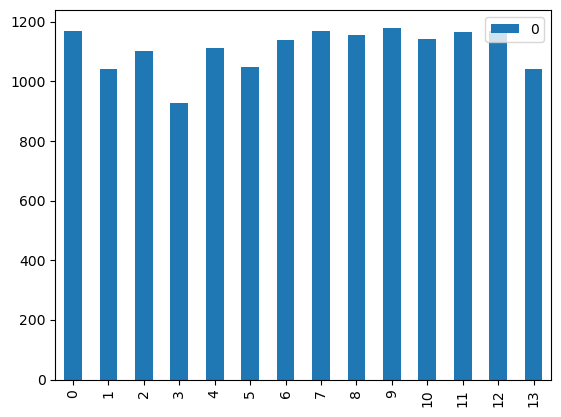

In [168]:
# plot monthly input values
pd.DataFrame(monthly_demand).plot(kind='bar')

<Axes: >

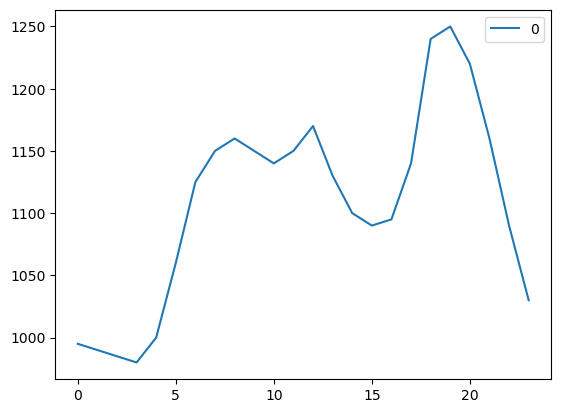

In [164]:
# plot daily input values
pd.DataFrame(daily_points).plot()

<Axes: >

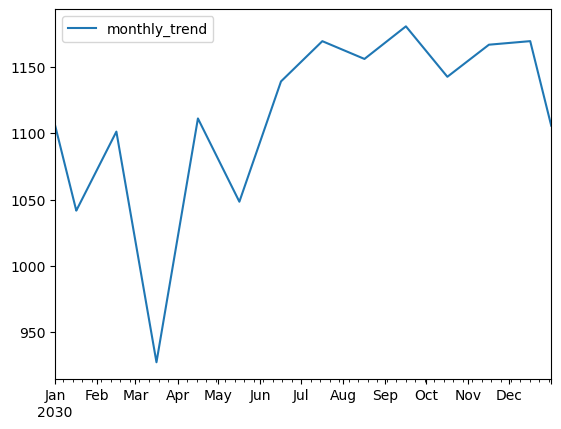

In [190]:
# interpolate hourly values from monthly averages
demand_series_df = pd.DataFrame({'monthly_trend': monthly_demand}, index=monthly_datetimes)
demand_series_df = demand_series_df.resample('H').interpolate('linear')
demand_series_df = demand_series_df['{}-01-01'.format(year) : '{}-12-31'.format(year)]
demand_series_df.plot()

In [191]:
# get hourly deviation from daily average
hourly_trend = [x - np.mean(daily_points) for x in daily_points]
hourly_trend

[-113.33333333333326,
 -118.33333333333326,
 -123.33333333333326,
 -128.33333333333326,
 -108.33333333333326,
 -48.33333333333326,
 16.666666666666742,
 41.66666666666674,
 51.66666666666674,
 41.66666666666674,
 31.666666666666742,
 41.66666666666674,
 61.66666666666674,
 21.666666666666742,
 -8.333333333333258,
 -18.333333333333258,
 -13.333333333333258,
 31.666666666666742,
 131.66666666666674,
 141.66666666666674,
 111.66666666666674,
 51.66666666666674,
 -18.333333333333258,
 -78.33333333333326]

In [192]:
# calculate hourly deviation for each hour in full timeseries
demand_series_df.insert(1, 'hourly_trend', [hourly_trend[x.hour] for x in demand_series_df.index.to_series()])
demand_series_df

,monthly_trend,hourly_trend
2030-01-01 00:00:00,1105.510753,-113.333333
2030-01-01 01:00:00,1105.339129,-118.333333
2030-01-01 02:00:00,1105.167505,-123.333333
2030-01-01 03:00:00,1104.995881,-128.333333
2030-01-01 04:00:00,1104.824257,-108.333333
...,...,...
2030-12-31 19:00:00,1106.368872,141.666667
2030-12-31 20:00:00,1106.197248,111.666667
2030-12-31 21:00:00,1106.025624,51.666667
2030-12-31 22:00:00,1105.854000,-18.333333


In [207]:
# add up monthly and hourly values for each hour in timeseries
final_demand_df = demand_series_df.sum(axis=1)['{}-01-01'.format(year):'{}-12-31'.format(year)]
final_demand_df

2030-01-01 00:00:00     992.177419
2030-01-01 01:00:00     987.005795
2030-01-01 02:00:00     981.834172
2030-01-01 03:00:00     976.662548
2030-01-01 04:00:00     996.490924
                          ...     
2030-12-31 19:00:00    1248.035539
2030-12-31 20:00:00    1217.863915
2030-12-31 21:00:00    1157.692291
2030-12-31 22:00:00    1087.520667
2030-12-31 23:00:00    1027.349043
Freq: H, Length: 8760, dtype: float64

In [208]:
# get total demand over the course of a year
final_demand_df.sum()

9751543.394777264

<Axes: >

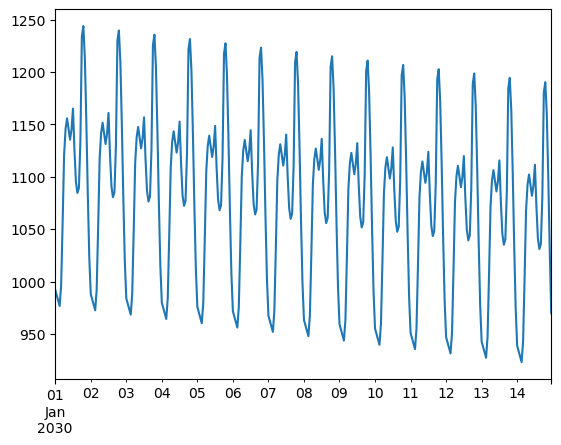

In [209]:
# plot first 2 weeks of data
final_demand_df['2030-01-01':'2030-01-14'].plot()

<Axes: >

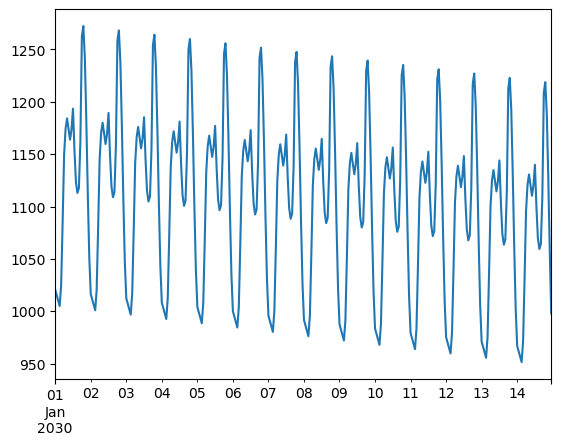

In [210]:
# find difference in final energy modelled compared to target number for given year
# calculate average hourly difference, and substract from each value in time series
final_demand_df = final_demand_df - ((final_demand_df.sum()-total_energy*1000.)/len(final_demand_df))
final_demand_df['2030-01-01':'2030-01-14'].plot()

In [211]:
# check that total energy is now as required: should be very small number
final_demand_df.sum() - total_energy*1000.

3.725290298461914e-09

In [205]:
# save timeseries to calliope model location using correct formatting
(final_demand_df*-1.).to_csv('../calliope_zambia/timeseries_data/zambia_demand_v1_{}.csv'.format(year), index_label='', date_format='%Y-%m-%d %H:%M')